## Load data

- Step1: Get image path list
- Step2: Split dataset Train/Test
- Step3: Move Test image to `testdata` floder
- Step4: Visulize data

In [5]:
import glob
import time
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Step1
cars_path = './data/vehicles'
not_cars_path = './data/non-vehicles'

cars = glob.glob(cars_path+'/*/*.png')
not_cars = glob.glob(not_cars_path+'/*/*.png')
print('The number of car samples: {}'.format(len(cars)))
print('The number of not car samples: {}'.format(len(not_cars)))

The number of car samples: 8792
The number of not car samples: 8968


## Augmented data

In [7]:
import cv2
import os
for car_path in cars:
    img = cv2.imread(car_path)
    save_path, file_name = os.path.split(car_path)
    h_flip = cv2.flip(img, 1)
    cv2.imwrite(os.path.join(save_path,'h_flip_'+file_name), h_flip)
    
for not_car_path in not_cars:
    img = cv2.imread(not_car_path)
    save_path, file_name = os.path.split(not_car_path)
    h_flip = cv2.flip(img, 1)
    cv2.imwrite(os.path.join(save_path,'h_flip_'+file_name), h_flip)

In [8]:
#Step2
state = np.random.randint(0, 100)
train_cars_path, test_cars_path  = train_test_split(cars, test_size=0.1, random_state=state)
train_not_cars_path, test_not_cars_path = train_test_split(not_cars, test_size=0.1, random_state=state)
print('Train Cars num: %d \t\t   Test Cars num: %d' % (len(train_cars_path), len(test_cars_path)))
print('Train not cars num: %d\t\tTest not cars num: %d' % (len(train_not_cars_path), len(test_not_cars_path)))

Train Cars num: 7912 		   Test Cars num: 880
Train not cars num: 8071		Test not cars num: 897


In [9]:
#Step3
import os
testdir = 'testdata'
veh_folder = os.path.join(testdir, 'vehicles')
non_vehicles_folder = os.path.join(testdir, 'non-vehicles')
if not os.path.exists(veh_folder):
    os.makedirs(veh_folder)
if not os.path.exists(non_vehicles_folder):
    os.makedirs(non_vehicles_folder)

    
for i, cars_path in enumerate(test_cars_path):
    filename = "image-%05d" % (i+1)
    file_type = os.path.split(cars_path)[1][-4:]
    Newdir = os.path.join(veh_folder,filename+file_type)
    os.rename(cars_path, Newdir)

for i, not_car_path in enumerate(test_not_cars_path):
    filename = "image-%05d" % (i+1)
    file_type = os.path.split(not_car_path)[1][-4:]
    Newdir = os.path.join(non_vehicles_folder,filename+file_type)
    os.rename(not_car_path, Newdir)

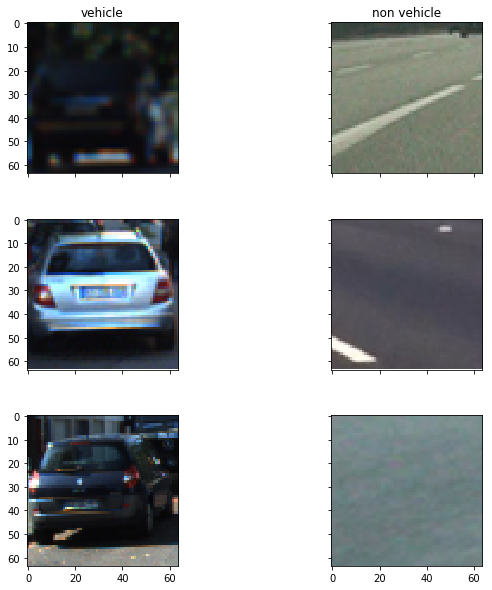

In [5]:
#visualize data

fig, axs = plt.subplots(3, 2, figsize = (10, 10), sharex = True, sharey = True)
for row, n in enumerate(np.random.randint(0, 1000, 3)):
    vehicle_img = mpimg.imread(train_cars_path[n])
    non_vehicle_img = mpimg.imread(train_not_cars_path[n])
    axs[row, 0].imshow(vehicle_img)
    axs[row, 1].imshow(non_vehicle_img)
fig.subplots_adjust(hspace = 0.3)
axs[0,0].set_title('vehicle')
axs[0,1].set_title('non vehicle')
fig.savefig('output_images/visulize.png')

##  Use ImageDataGenerator creating Train&Test data

In [10]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'data',
        target_size=(64, 64),
        batch_size=batch_size)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        'testdata',
        target_size=(64, 64),
        batch_size=batch_size)

Using TensorFlow backend.


Found 33743 images belonging to 2 classes.
Found 1777 images belonging to 2 classes.


## Build Model

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Reshape, Lambda, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

def CNN_model(input_shape = (64, 64, 3), is_training = True):
        model = Sequential()
        model.add(Lambda( lambda x : x / 127.5 - 1., input_shape= input_shape))
        model.add(Conv2D(64, (5, 5), activation="relu", padding = "same"))
        model.add(MaxPooling2D(pool_size = (2,2)))

        model.add(Conv2D(128, (3, 3), padding = "same", activation="relu"))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Conv2D(128, (3, 3), padding = "same", activation="relu"))
        model.add(MaxPooling2D(pool_size = (2,2)))  
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        #this layer acts like a dense layer with 128 units but we keep it fully convolutional
        model.add(Conv2D(64, (8,8), activation = "relu"))
        model.add(Dropout(0.2))   
    
        model.add(Conv2D(2, (1,1)))
        model.add(Activation(K.softmax))
    
        if is_training:
            model.add(Reshape( (2,) ))
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
        return model

In [12]:
model = CNN_model()
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='./output_images/model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
__________

In [13]:
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
import keras
history = History()
model_checkpoint = ModelCheckpoint('temp_model.hdf5', monitor='loss', save_best_only=True)
tb_cb = keras.callbacks.TensorBoard(log_dir='log', write_images=1, histogram_freq=0)
# 设置log的存储位置，将网络权值以图片格式保持在tensorboard中显示，设置每一个周期计算一次网络的
# 权值，每层输出值的分布直方图
callbacks = [history,model_checkpoint,tb_cb]

In [14]:
'''
cars_path = './data/vehicles'
not_cars_path = './data/non-vehicles'

cars = glob.glob(cars_path+'/*/*.png')
not_cars = glob.glob(not_cars_path+'/*/*.png')
print('The number of car samples: {}'.format(len(cars)))
print('The number of not car samples: {}'.format(len(not_cars)))

train_num_sampels = len(train_cars_path) + len(train_not_cars_path)
print(train_num_sampels)
test_num_sampels = len(test_cars_path) + len(test_not_cars_path)
print(test_num_sampels)
'''
history_object = model.fit_generator(
        train_generator,
        steps_per_epoch= 33743  // batch_size,
        epochs= 10,
        callbacks=callbacks,
        validation_data = test_generator,
        validation_steps = 1777  // batch_size)

Epoch 1/10
527/527 [==============================] - 149s 283ms/step - loss: 0.1240 - acc: 0.9575 - val_loss: 0.0525 - val_acc: 0.9826
Epoch 2/10
527/527 [==============================] - 142s 270ms/step - loss: 0.0443 - acc: 0.9854 - val_loss: 0.0264 - val_acc: 0.9873
Epoch 3/10
527/527 [==============================] - 142s 270ms/step - loss: 0.0313 - acc: 0.9900 - val_loss: 0.0462 - val_acc: 0.9850
Epoch 4/10
527/527 [==============================] - 142s 270ms/step - loss: 0.0277 - acc: 0.9905 - val_loss: 0.0135 - val_acc: 0.9948
Epoch 5/10
527/527 [==============================] - 143s 272ms/step - loss: 0.0202 - acc: 0.9937 - val_loss: 0.0161 - val_acc: 0.9954
Epoch 6/10
527/527 [==============================] - 142s 270ms/step - loss: 0.0225 - acc: 0.9927 - val_loss: 0.0660 - val_acc: 0.9763
Epoch 7/10
527/527 [==============================] - 142s 269ms/step - loss: 0.0172 - acc: 0.9945 - val_loss: 0.0670 - val_acc: 0.9844
Epoch 8/10
527/527 [============================

In [15]:
model.save('./model/model.h5')
print("Model Saved!")

Model Saved!


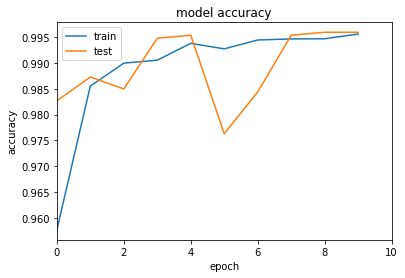

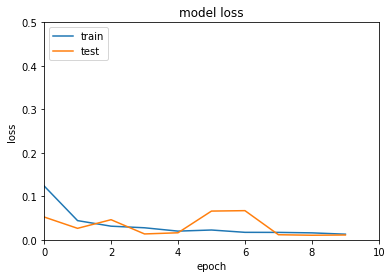

In [16]:

from matplotlib import pyplot as plt
history=history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlim(0,10)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('output_images/acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlim(0, 10)
plt.ylim(0, 0.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('out')
plt.show()


## Test Model

In [17]:
#build a heatmap with cnn
from scipy.misc import imresize
import numpy as np
def gen_heatmap(model,img, class_index):
    img_crop = img[400:660,:,:]
    img_crop = imresize(img_crop,(260, 1280))
    img_crop = np.expand_dims(img_crop, axis = 0)
    heatmap = model.predict(img_crop)
    print(heatmap.shape)
    heatmap[ heatmap < 0.99 ] = 0
    heatmap[ heatmap >= 0.99] = 1
    heatmap2 = np.squeeze(heatmap)[:, :, class_index]
    return heatmap2

In [18]:
model = CNN_model(input_shape = (260, 1280, 3), is_training = False)
model.load_weights('./model/model.h5')

img = mpimg.imread("test_images/test5.jpg")

(1, 25, 153, 2)


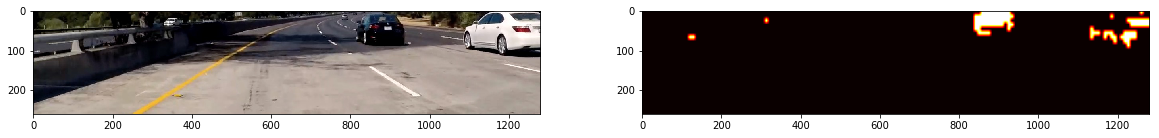

In [19]:
heatmap = gen_heatmap(model, img, 1)
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1, 2, 1)
plt.imshow(img[400:660])
fig.add_subplot(1, 2, 2)
plt.imshow(imresize(heatmap, (260, 1280)) , cmap = 'hot')

(1, 25, 153, 2)


Text(0.5,1,'blob to rectangle boxes of cars')

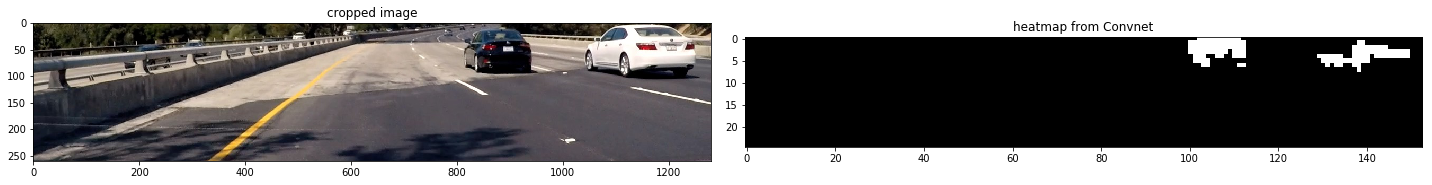

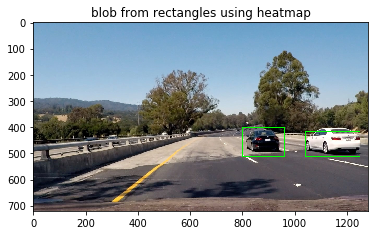

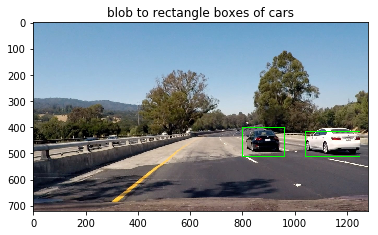

In [21]:
#get bounding boxes from the heatmap
import cv2

def get_bboxes(heatmap):
     xx, yy = np.meshgrid(np.arange(heatmap.shape[1]),np.arange(heatmap.shape[0]))
     x = (xx[heatmap == 1])
     y = (yy[heatmap == 1])
     boxpts = []
     for i,j in zip(x,y):
        topleft = [i*8, j*8 + 400]
        topright = [i*8 + 64, j*8 + 400]
        botright = [i*8 + 64, j*8 + 464]
        botleft = [i*8, j*8 + 464]
        boxpts.append( np.array([topleft, topright, botright, botleft])  )  
     return boxpts

def draw_voting_boxes(img, bboxes, minvotesforbox = 3):
    #generate filled rectangles from box and use it to vote on regions that could contain the car
    im2 = np.zeros(img.shape[0:2], dtype = np.uint8)
    for box in bboxes:
        mask = np.zeros(img.shape[0:2], dtype = np.uint8)
        im2 += cv2.fillPoly(mask, [box], (1,))
    im2 [ im2 < minvotesforbox ] = 0  
    return im2

#create a binary mask and get bounding rectangles from blobs
def drawcarboxes(img, bboxes):
    mask = np.zeros(img.shape[0:2], dtype = np.uint8)
    mask = draw_voting_boxes(mask, bboxes, 3)

    # find contours
    _, cnt, _ = cv2.findContours(mask, cv2.RETR_TREE,
                cv2.CHAIN_APPROX_SIMPLE)
    labeledimg = img.copy()
    
    car_boxes  = []
    for c in cnt:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(labeledimg,(x,y),(x+w,y+h),(0,255,0),2)
        car_boxes.append( (x,y,w,h) )
    return labeledimg, car_boxes

#draw boxes from heatmap on image
img = mpimg.imread("test_images/test4.jpg")
heatmap = gen_heatmap(model, img, 1)
bboxes = get_bboxes(heatmap)
im2, _ = drawcarboxes(img, bboxes)

# show plots
f = plt.figure(figsize = (20, 10))
ax1 = f.add_subplot(1, 2, 1)
ax1.imshow(img[400:660])
ax1.set_title('cropped image')
ax2 = f.add_subplot(1, 2, 2)
ax2.imshow(heatmap, cmap = 'gray')
ax2.set_title('heatmap from Convnet')
f.tight_layout()


plt.figure()
plt.imshow(im2)
plt.title('blob from rectangles using heatmap')

labeledimg, _ = drawcarboxes(img, bboxes)
plt.figure()
plt.imshow(labeledimg)
plt.title('blob to rectangle boxes of cars')